In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb # XGBoost implementation

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
train = pd.read_csv("/content/drive/My Drive/dataset/train.csv")
test = pd.read_csv("/content/drive/My Drive/dataset/test.csv/test.csv")

features = [x for x in train.columns if x not in ['id','loss']]
#print(features)

cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


NameError: ignored

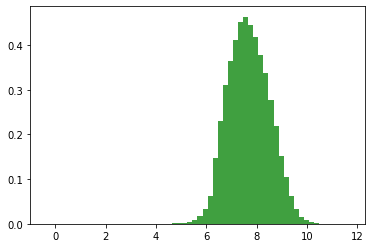

In [0]:
from scipy.stats import norm, lognorm
#import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

train['log_loss'] = np.log(train['loss'])

# fit the normal distribution on ln(loss)
(mu, sigma) = norm.fit(train['log_loss'])

# the histogram of the ln(loss)
n, bins, patches = plt.hist(train['log_loss'], 60, normed=1, facecolor='green', alpha=0.75)

# add the fitted line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Ln(loss)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Ln(Loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train[features], test[features])).reset_index(drop=True)
for c in range(len(cat_features)):
    train_test[cat_features[c]] = train_test[cat_features[c]].astype('category').cat.codes

train_x = train_test.iloc[:ntrain,:]
test_x = train_test.iloc[ntrain:,:]


In [0]:
xgdmat = xgb.DMatrix(train_x, train['log_loss']) # Create our DMatrix to make XGBoost more efficient

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3} 

# Grid Search CV optimized settings
num_rounds = 100
bst = xgb.train(params, xgdmat, num_boost_round = num_rounds)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,feature,fscore
0,cat16,0.000307
1,cat29,0.000307
2,cat84,0.000307
3,cat99,0.000307
4,cat95,0.000307
...,...,...
78,cat111,0.044240
79,cat100,0.048541
80,cat101,0.050691
81,cont7,0.078034


<Figure size 432x288 with 0 Axes>

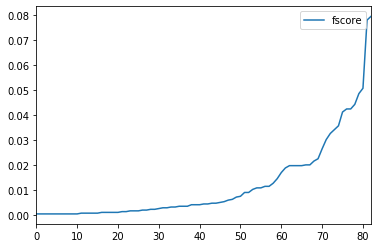

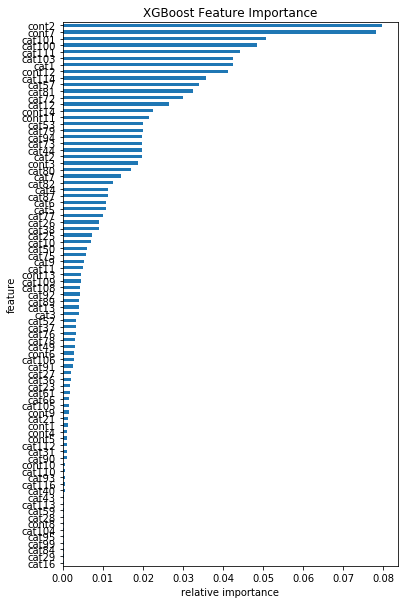

In [0]:
import operator

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
ceate_feature_map(features)

importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

df


In [0]:
test_xgb = xgb.DMatrix(test_x)
submission = pd.read_csv("/content/drive/My Drive/dataset/sample_submission.csv")
submission.iloc[:, 1] = np.exp(bst.predict(test_xgb))
submission.to_csv('xgb_starter.sub.csv', index=None)